<a href="https://colab.research.google.com/github/AshwinDeshpande96/Machine-Translation/blob/master/NMT_Hindi_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import inflect
from google.colab import files

print(tf.__version__)

1.14.0-rc1


# 1. Data Preprocessing

## 1.1. Upload files

In [2]:
uploaded = files.upload()

## 1.2. Filtering functions

In [0]:
#unicode to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
#numbers add up to extraneous words in the vocabulary
#hence we convert it to words so that numbers are now made of
# individual words: 1979 --> One thousand and seventy nine
def replace_numbers(text):
    p = inflect.engine()
    w = re.findall(r"[0-9]+", text)
    for num in w:
        text = text.replace(num, p.number_to_words(num))
    return text
#function does the following:
# 1- Reduce redundancy
#  1.1- by reducing words with two or more instances of uppercase and lowercase inflections
#  1.2- by replacing numbers with word equivalents
#  1.3- by reducing punctuation
# 2- Add delimiters
def preprocess_sentence(w, language='english'):
    if language != 'hindi':
        w = unicode_to_ascii(w.lower().strip())
        w = replace_numbers(w)
    
    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿-])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    if language != 'hindi':
        # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    w = '<start> ' + w + ' <end>'
    return w
#function creates pair of sentences from language1 to language2
def create_dataset(language_1_path, language_2_path):
    english = open(language_1_path, encoding='UTF-8').read().strip().split('\n')
    hindi = open(language_2_path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(eng), preprocess_sentence(hin, language='hindi')] for eng, hin in zip(english, hindi)]
    
    return word_pairs

## 1.3. Encapsulting Language Class

In [0]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
    
        self.create_index()
    
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
    
        self.vocab = sorted(self.vocab)
    
        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1
    
        for word, index in self.word2idx.items():
            self.idx2word[index] = word

## 1.4. Dataset

In [0]:
#get length of the longest sentence
def max_length(tensor):
    return max(len(t) for t in tensor)

#create input and target tensors
def load_dataset(language_1_path, language_2_path):
    # creating language1 to language2 pairs
    pairs = create_dataset(language_1_path, language_2_path)

    #create languages and their vocabulary
    # "i am a programmer" --> "2 23 45 9"
    #where vocabulary(2)=i, vocabulary(23)=am, vocabulary(45)=a, vocabulary(9) = programmer
    inp_lang = LanguageIndex(en for en, hi in pairs)
    targ_lang = LanguageIndex(hi for en, hi in pairs)
    
    # Vectorize the input and target languages
    
    #English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, hi in pairs]
    
    #Hindi sentences
    target_tensor = [[targ_lang.word2idx[s] for s in hi.split(' ')] for en, hi in pairs]
    

    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    #pad sentences so that every sentence is of same length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [6]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset('/content/english.txt', '/content/hindi.txt')
print("Input shape: ", input_tensor.shape)
print("Target shape: ", target_tensor.shape)

Input shape:  (3027, 92)
Target shape:  (3027, 92)


In [7]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.15, random_state=23)
# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(2572, 2572, 455, 455)

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# 2. Network Architecture

In [0]:
def gru(units):
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [29]:
EPOCHS = 15

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2157
Epoch 1 Loss 0.2335
Time taken for 1 epoch 65.73550987243652 sec

Epoch 2 Batch 0 Loss 0.2010
Epoch 2 Loss 0.2278
Time taken for 1 epoch 66.13814759254456 sec

Epoch 3 Batch 0 Loss 0.2014
Epoch 3 Loss 0.2197
Time taken for 1 epoch 65.91569662094116 sec

Epoch 4 Batch 0 Loss 0.1946
Epoch 4 Loss 0.2114
Time taken for 1 epoch 66.58022165298462 sec

Epoch 5 Batch 0 Loss 0.1845
Epoch 5 Loss 0.2034
Time taken for 1 epoch 65.80890321731567 sec

Epoch 6 Batch 0 Loss 0.1830
Epoch 6 Loss 0.1946
Time taken for 1 epoch 65.99909329414368 sec

Epoch 7 Batch 0 Loss 0.1738
Epoch 7 Loss 0.1883
Time taken for 1 epoch 65.41103529930115 sec

Epoch 8 Batch 0 Loss 0.1638
Epoch 8 Loss 0.1808
Time taken for 1 epoch 65.64159178733826 sec

Epoch 9 Batch 0 Loss 0.1558
Epoch 9 Loss 0.1726
Time taken for 1 epoch 65.81996488571167 sec

Epoch 10 Batch 0 Loss 0.1546
Epoch 10 Loss 0.1678
Time taken for 1 epoch 64.84161496162415 sec

Epoch 11 Batch 0 Loss 0.1455
Epoch 11 Loss 0.1627
Time tak

In [0]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='Greys')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> the police were able to remove ganga and chandra kiran from the damaged car with some difficulty and took them to the sundernagar civil hospital . <end>
Predicted translation: पुलिस ने गंगा व चंद्र किरण को कड़ी मशक्कत के बाद क्षतिग्रस्त टैक्सी से बाहर निकाला और नागरिक अस्पताल सुंदरनगर ले गए। <end> 


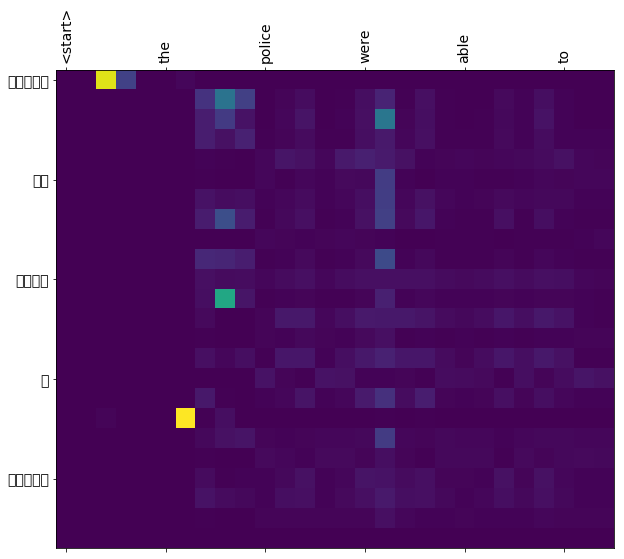

In [43]:
translate(u'The police were able to remove Ganga and Chandra Kiran from the damaged car with some difficulty and took them to the Sundernagar civil hospital.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)